In [1]:
from log_file_breakdown import *
warnings.filterwarnings('ignore')
sns.set(context='paper')
%matplotlib inline

In [2]:
machine_to_analyze = 'm1'
dataset_restriction = -1
column_restriction = -3
datasets = ['susy', 'higgs', 'url', 'kdda'][:dataset_restriction]
fractions = [
'1.0',
'0.6667',
'0.5',
'0.4',
'0.3333',
'0.2857',
'0.25',
'0.2222',
'0.2',
'0.1818',
'0.1667',
'0.1538',
'0.1429',
'0.1333',
'0.125'
]
fraction_indices = [0, 1, 2, 3, 6, 14]
columns = ['comm', 'full', 'comp', 'fractional', 'skew', 'filler'][:column_restriction]
num_columns = len(columns)
dataset_names = ['SUSY', 'HIGGS', 'URL-Combined', 'KDDA'][:dataset_restriction]
num_datasets = len(datasets)
total_machines = 13
trials = 10

In [3]:
data_dir = '../../data'
synthetic_comm_dir = data_dir + '/synth_comm_times/' + machine_to_analyze
synthetic_comm_dir_30_trials = data_dir + '/synth_comm_times_30_trials/' + machine_to_analyze
real_comm_dir = data_dir + '/real_comm_times/' + machine_to_analyze
real_comm_dir_30_trials = data_dir + '/real_comm_times_30_trials/' + machine_to_analyze
real_dir = data_dir + '/real_times/' + machine_to_analyze
real_dir_30_trials = data_dir + '/real_times_30_trials/' + machine_to_analyze
real_fraction_dir = data_dir + '/real_fractional_times_30_trials/' + machine_to_analyze


In [4]:
comm_dirs = get_subdirectories(real_comm_dir_30_trials)
full_dirs = get_subdirectories(real_dir_30_trials)
fractional_dirs = get_subdirectories(real_fraction_dir)

In [5]:
init_dict = {}
for dataset in datasets:
    comm_dataset_subdirs = filter_dirs_by_dataset(comm_dirs, dataset)
    full_dataset_subdirs = filter_dirs_by_dataset(full_dirs, dataset)
    fractional_dataset_subdirs = filter_dirs_by_dataset(fractional_dirs, dataset)
    init_dict[dataset] = {}
    for machine_index, machine_count in enumerate(range(2, total_machines + 1)):
        init_dict[dataset][machine_count] = {}
        comm_subdir = filter_dirs_by_machines(comm_dataset_subdirs, machine_count)[0]
        real_subdir = filter_dirs_by_machines(full_dataset_subdirs, machine_count)[0]
        if machine_index in fraction_indices and num_columns > 3:
            fractional_subdir =  filter_dirs_by_fraction(fractional_dataset_subdirs, fractions[machine_index])[0]
        comm_scale_init = []
        full_scale_init = []
        fractional_scale_init = []
        for idx in range(trials):
            comm_init = get_init(comm_subdir, real_comm_dir_30_trials, idx)
            full_init = get_init(real_subdir, real_dir_30_trials, idx)
            comm_scale_init.append(comm_init[1])
            full_scale_init.append(full_init[1])
            if machine_index in fraction_indices and num_columns > 3:
                fractional_init = get_init(fractional_subdir, real_fraction_dir, idx)
                fractional_scale_init.append(fractional_init[1])
        init_dict[dataset][machine_count]['comm'] = comm_scale_init
        init_dict[dataset][machine_count]['full'] = full_scale_init
        init_dict[dataset][machine_count]['fractional'] = fractional_scale_init

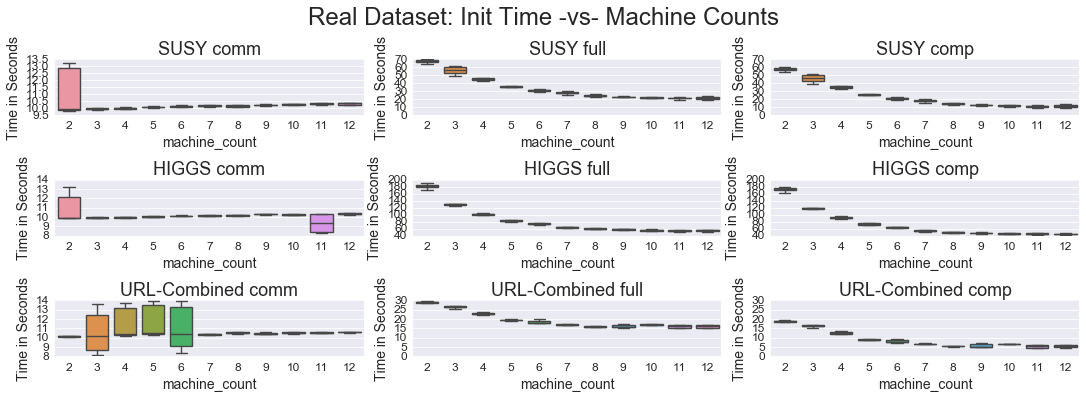

In [6]:
fig, axs = plt.subplots(num_datasets, num_columns, figsize=(15,5))
if num_datasets > 1:
    for i in range(num_datasets):
        axs[i][2] = plt.subplot(num_datasets, num_columns, i*num_columns + 3,  sharey=axs[i][1])
        if num_columns > 3:
            axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][1])
else:
    axs[2] = plt.subplot(num_datasets, num_columns, 3,  sharey=axs[1])
    if num_columns > 3:
        axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][1])
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(columns):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_count in range(2, total_machines + 1):
            for k in range(trials):
                if exp_type == 'comp':
                    comp = init_dict[dataset][machine_count]['full'][k] - np.median(init_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [comp, machine_count]
                else:
                    if exp_type in ['fractional', 'skew']:
                        if machine_count - 2 in fraction_indices:
                            frac = init_dict[dataset][machine_count]['fractional'][k] - np.median(init_dict[dataset][2]['comm'])
                            if exp_type == 'fractional':
                                df.loc[trials*(machine_count - 2) + k] = [frac, machine_count]
                            else:
                                comp = init_dict[dataset][machine_count]['full'][k] - np.median(init_dict[dataset][machine_count]['comm'])
                                df.loc[trials*(machine_count - 2) + k] = [comp - frac, machine_count]
                        else:
                            df.loc[trials*(machine_count - 2) + k] = [0, machine_count]
                    else:
                        df.loc[trials*(machine_count - 2) + k] = [init_dict[dataset][machine_count][exp_type][k], machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[dataset_index][exp_type_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Init Time -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [7]:
job_1_dict = {}
for dataset in datasets:
    comm_dataset_subdirs = filter_dirs_by_dataset(comm_dirs, dataset)
    full_dataset_subdirs = filter_dirs_by_dataset(full_dirs, dataset)
    fractional_dataset_subdirs = filter_dirs_by_dataset(fractional_dirs, dataset)
    job_1_dict[dataset] = {}
    for machine_index, machine_count in enumerate(range(2, total_machines + 1)):
        job_1_dict[dataset][machine_count] = {}
        comm_subdir = filter_dirs_by_machines(comm_dataset_subdirs, machine_count)[0]
        real_subdir = filter_dirs_by_machines(full_dataset_subdirs, machine_count)[0]
        if machine_index in fraction_indices and num_columns > 3:
            fractional_subdir =  filter_dirs_by_fraction(fractional_dataset_subdirs, fractions[machine_index])[0]
        comm_scale_job_1 = []
        full_scale_job_1 = []
        fractional_scale_job_1 = []
        for idx in range(trials):
            comm_jobs = get_jobs(comm_subdir, real_comm_dir_30_trials, idx)
            full_jobs = get_jobs(real_subdir, real_dir_30_trials, idx)
            comm_scale_job_1.append(comm_jobs[1])
            full_scale_job_1.append(full_jobs[1])
            if machine_index in fraction_indices and num_columns > 3:
                fractional_jobs = get_jobs(fractional_subdir, real_fraction_dir, idx)
                fractional_scale_job_1.append(fractional_jobs[1])
        job_1_dict[dataset][machine_count]['comm'] = comm_scale_job_1
        job_1_dict[dataset][machine_count]['full'] = full_scale_job_1
        job_1_dict[dataset][machine_count]['fractional'] = fractional_scale_job_1

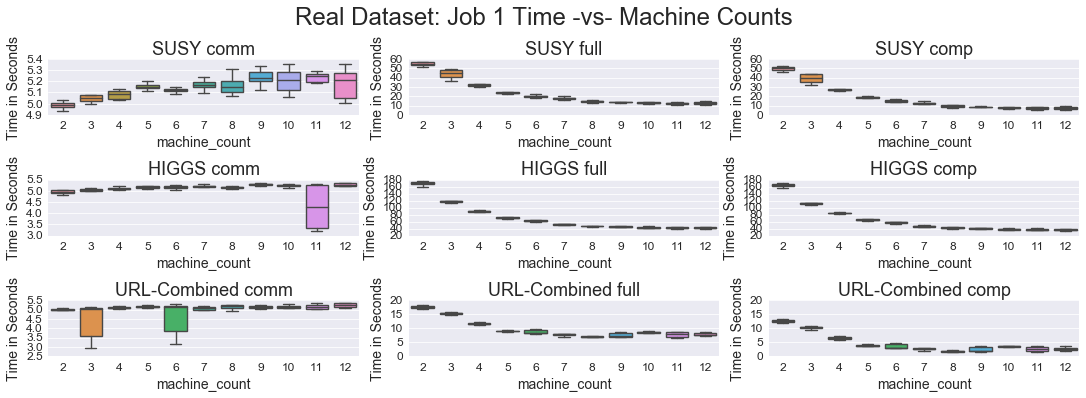

In [8]:
fig, axs = plt.subplots(num_datasets, num_columns, figsize=(15,5))
if num_datasets > 1:
    for i in range(num_datasets):
        axs[i][2] = plt.subplot(num_datasets, num_columns, i*num_columns + 3,  sharey=axs[i][1])
        if num_columns > 3:
            axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][1])
else:
    axs[2] = plt.subplot(num_datasets, num_columns, 3,  sharey=axs[1])
    axs[3] = plt.subplot(num_datasets, num_columns, 4,  sharey=axs[1])
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(columns):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_count in range(2, total_machines + 1):
            for k in range(trials):
                if exp_type == 'comp':
                    comp = job_1_dict[dataset][machine_count]['full'][k] - np.median(job_1_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [comp, machine_count]
                else:
                    if exp_type in ['fractional', 'skew']:
                        if machine_count - 2 in fraction_indices:
                            frac = job_1_dict[dataset][machine_count]['fractional'][k] - np.median(job_1_dict[dataset][2]['comm'])
                            if exp_type == 'fractional':
                                df.loc[trials*(machine_count - 2) + k] = [frac, machine_count]
                            else:
                                comp = job_1_dict[dataset][machine_count]['full'][k] - np.median(job_1_dict[dataset][machine_count]['comm'])
                                df.loc[trials*(machine_count - 2) + k] = [comp - frac, machine_count]
                        else:
                            df.loc[trials*(machine_count - 2) + k] = [0, machine_count]
                    else:
                        df.loc[trials*(machine_count - 2) + k] = [job_1_dict[dataset][machine_count][exp_type][k], machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[dataset_index][exp_type_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Job 1 Time -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [9]:
diff_dict = {}
for dataset in datasets:
    comm_dataset_subdirs = filter_dirs_by_dataset(comm_dirs, dataset)
    full_dataset_subdirs = filter_dirs_by_dataset(full_dirs, dataset)
    fractional_dataset_subdirs = filter_dirs_by_dataset(fractional_dirs, dataset)
    diff_dict[dataset] = {}
    for machine_index, machine_count in enumerate(range(2, total_machines + 1)):
        diff_dict[dataset][machine_count] = {}
        comm_subdir = filter_dirs_by_machines(comm_dataset_subdirs, machine_count)[0]
        real_subdir = filter_dirs_by_machines(full_dataset_subdirs, machine_count)[0]
        if machine_index in fraction_indices and num_columns > 3:
            fractional_subdir =  filter_dirs_by_fraction(fractional_dataset_subdirs, fractions[machine_index])[0]
        comm_scale_diff = []
        full_scale_diff = []
        fractional_scale_diff = []
        for idx in range(trials):
            comm_diffs = sum(get_diff(comm_subdir, real_comm_dir_30_trials, idx))
            full_diffs = sum(get_diff(real_subdir, real_dir_30_trials, idx))
            comm_scale_diff.append(comm_diffs)
            full_scale_diff.append(full_diffs)
            if machine_index in fraction_indices and num_columns > 3:
                fractional_diffs = sum(get_diff(fractional_subdir, real_fraction_dir, idx))
                fractional_scale_diff.append(fractional_diffs)
        diff_dict[dataset][machine_count]['comm'] = comm_scale_diff
        diff_dict[dataset][machine_count]['full'] = full_scale_diff
        diff_dict[dataset][machine_count]['fractional'] = fractional_scale_diff

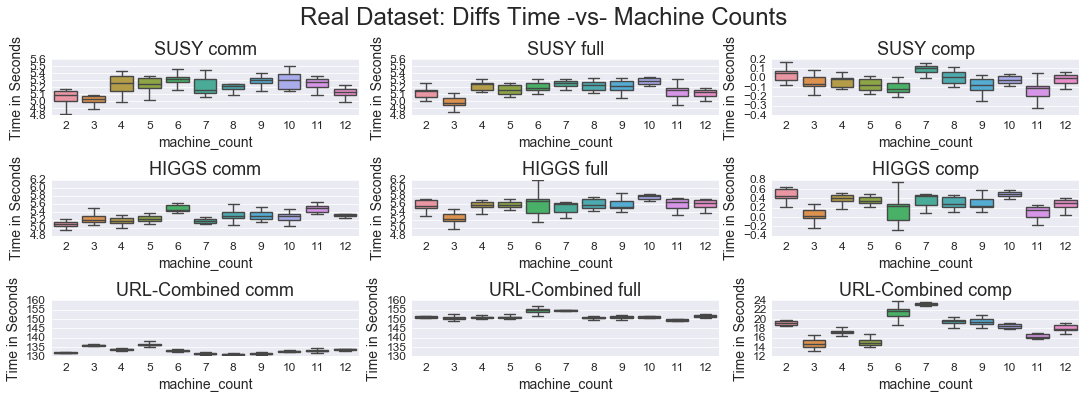

In [10]:
fig, axs = plt.subplots(num_datasets, num_columns, figsize=(15,5))
if num_datasets > 1:
    for i in range(num_datasets):
        axs[i][1] = plt.subplot(num_datasets, num_columns, i*num_columns + 2,  sharey=axs[i][0])
        if num_columns > 3:
            axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][2])
else:
    axs[1] = plt.subplot(num_datasets, num_columns, 2,  sharey=axs[0])
    axs[3] = plt.subplot(num_datasets, num_columns, 4,  sharey=axs[2])
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(columns):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_count in range(2, total_machines + 1):
            for k in range(trials):
                if exp_type == 'comp':
                    comp = diff_dict[dataset][machine_count]['full'][k] - np.median(diff_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [comp, machine_count]
                else:
                    if exp_type in ['fractional', 'skew']:
                        if machine_count - 2 in fraction_indices:
                            frac = diff_dict[dataset][machine_count]['fractional'][k] - np.median(diff_dict[dataset][2]['comm'])
                            if exp_type == 'fractional':
                                df.loc[trials*(machine_count - 2) + k] = [frac, machine_count]
                            else:
                                comp = diff_dict[dataset][machine_count]['full'][k] - np.median(diff_dict[dataset][machine_count]['comm'])
                                df.loc[trials*(machine_count - 2) + k] = [comp - frac, machine_count]
                        else:
                            df.loc[trials*(machine_count - 2) + k] = [0, machine_count]
                    else:
                        df.loc[trials*(machine_count - 2) + k] = [diff_dict[dataset][machine_count][exp_type][k], machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[dataset_index][exp_type_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Diffs Time -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [11]:
epoch_sum_dict = {}
full_time_dict = {}
for dataset in datasets:
    comm_dataset_subdirs = filter_dirs_by_dataset(comm_dirs, dataset)
    full_dataset_subdirs = filter_dirs_by_dataset(full_dirs, dataset)
    fractional_dataset_subdirs = filter_dirs_by_dataset(fractional_dirs, dataset)
    epoch_sum_dict[dataset] = {}
    full_time_dict[dataset] = {}
    for machine_index, machine_count in enumerate(range(2, total_machines + 1)):
        epoch_sum_dict[dataset][machine_count] = {}
        full_time_dict[dataset][machine_count] = {}
        comm_subdir = filter_dirs_by_machines(comm_dataset_subdirs, machine_count)[0]
        real_subdir = filter_dirs_by_machines(full_dataset_subdirs, machine_count)[0]
        if machine_index in fraction_indices and num_columns > 3:
            fractional_subdir =  filter_dirs_by_fraction(fractional_dataset_subdirs, fractions[machine_index])[0]
        comm_scale_epoch_sum = []
        full_scale_epoch_sum = []
        fractional_scale_epoch_sum = []
        comm_scale_full_time = []
        full_scale_full_time = []
        fractional_scale_full_time = []
        for idx in range(trials):
            comm_all_times, comm_epochs = get_overheads(comm_subdir, real_comm_dir_30_trials, idx)
            full_all_times, full_epochs = get_overheads(real_subdir, real_dir_30_trials, idx)
            comm_scale_epoch_sum.append(sum(comm_epochs))
            full_scale_epoch_sum.append(sum(full_epochs))
            comm_scale_full_time.append(comm_all_times)
            full_scale_full_time.append(full_all_times)
            if machine_index in fraction_indices and num_columns > 3:
                fractional_all_times, fractional_epochs = get_overheads(fractional_subdir, real_fraction_dir, idx)
                fractional_scale_full_time.append(fractional_all_times)
                fractional_scale_epoch_sum.append(sum(fractional_epochs))
        epoch_sum_dict[dataset][machine_count]['comm'] = comm_scale_epoch_sum
        epoch_sum_dict[dataset][machine_count]['full'] = full_scale_epoch_sum
        epoch_sum_dict[dataset][machine_count]['fractional'] = fractional_scale_epoch_sum
        full_time_dict[dataset][machine_count]['comm'] = comm_scale_full_time
        full_time_dict[dataset][machine_count]['full'] = full_scale_full_time
        full_time_dict[dataset][machine_count]['fractional'] = fractional_scale_full_time

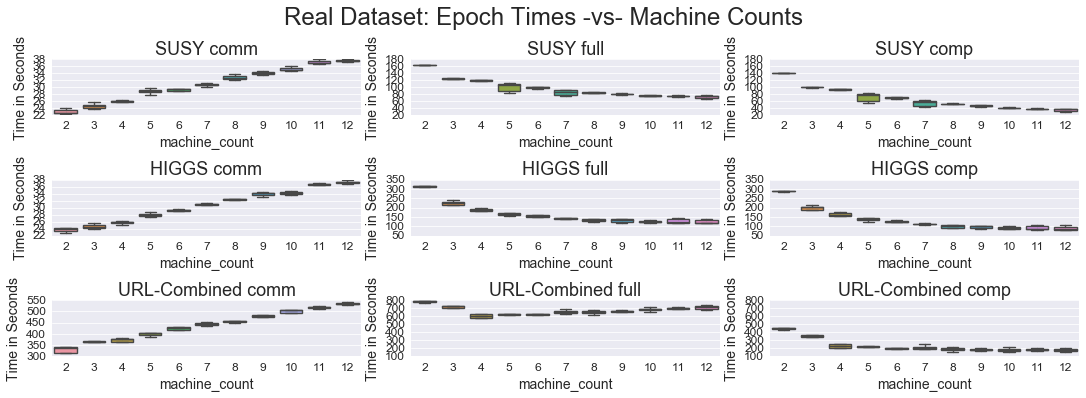

In [12]:
fig, axs = plt.subplots(num_datasets, num_columns, figsize=(15,5))
if num_datasets > 1:
    for i in range(num_datasets):
        axs[i][2] = plt.subplot(num_datasets, num_columns, i*num_columns + 3,  sharey=axs[i][1])
        if num_columns > 3:
            axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][1])
else:
    axs[2] = plt.subplot(num_datasets, num_columns, 3,  sharey=axs[1])
    axs[3] = plt.subplot(num_datasets, num_columns, 4,  sharey=axs[1])
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(columns):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_count in range(2, total_machines + 1):
            for k in range(trials):
                if exp_type == 'comp':
                    comp = epoch_sum_dict[dataset][machine_count]['full'][k] - np.median(epoch_sum_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [comp, machine_count]
                else:
                    if exp_type in ['fractional', 'skew']:
                        if machine_count - 2 in fraction_indices:
                            frac = epoch_sum_dict[dataset][machine_count]['fractional'][k] - np.median(epoch_sum_dict[dataset][2]['comm'])
                            if exp_type == 'fractional':
                                df.loc[trials*(machine_count - 2) + k] = [frac, machine_count]
                            else:
                                comp = epoch_sum_dict[dataset][machine_count]['full'][k] - np.median(epoch_sum_dict[dataset][machine_count]['comm'])
                                df.loc[trials*(machine_count - 2) + k] = [comp - frac, machine_count]
                        else:
                            df.loc[trials*(machine_count - 2) + k] = [0, machine_count]
                    else:
                        df.loc[trials*(machine_count - 2) + k] = [epoch_sum_dict[dataset][machine_count][exp_type][k], machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[dataset_index][exp_type_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Epoch Times -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

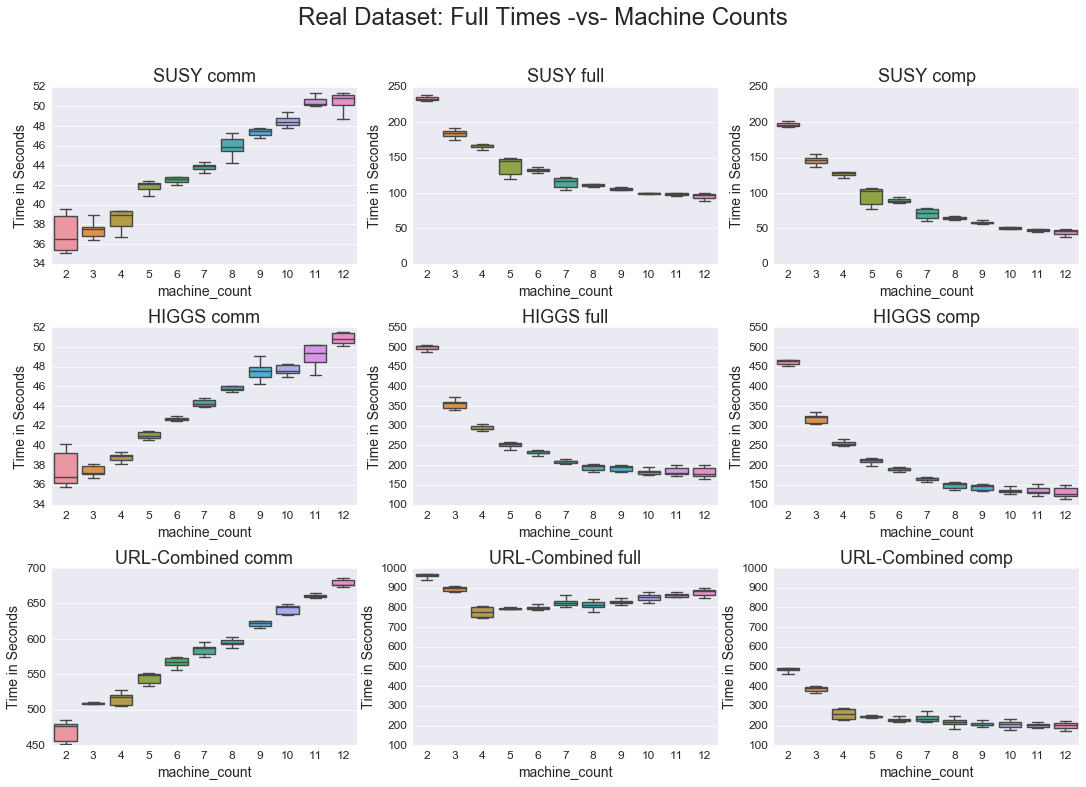

In [13]:
fig, axs = plt.subplots(num_datasets, num_columns, figsize=(15,10))
if num_datasets > 1:
    for i in range(num_datasets):
        axs[i][2] = plt.subplot(num_datasets, num_columns, i*num_columns + 3,  sharey=axs[i][1])
        if num_columns > 3:
            axs[i][3] = plt.subplot(num_datasets, num_columns, i*num_columns + 4,  sharey=axs[i][1])
else:
    axs[2] = plt.subplot(num_datasets, num_columns, 3,  sharey=axs[1])
    axs[3] = plt.subplot(num_datasets, num_columns, 4,  sharey=axs[1])
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(columns):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_count in range(2, total_machines + 1):
            for k in range(trials):
                if exp_type == 'comp':
                    comp = full_time_dict[dataset][machine_count]['full'][k] - np.median(full_time_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [comp, machine_count]
                else:
                    if exp_type in ['fractional', 'skew']:
                        if machine_count - 2 in fraction_indices:
                            frac = full_time_dict[dataset][machine_count]['fractional'][k] - np.median(full_time_dict[dataset][2]['comm'])
                            if exp_type == 'fractional':
                                df.loc[trials*(machine_count - 2) + k] = [frac, machine_count]
                            else:
                                comp = full_time_dict[dataset][machine_count]['full'][k] - np.median(full_time_dict[dataset][machine_count]['comm'])
                                df.loc[trials*(machine_count - 2) + k] = [comp - frac, machine_count]
                        else:
                            df.loc[trials*(machine_count - 2) + k] = [0, machine_count]
                    else:
                        df.loc[trials*(machine_count - 2) + k] = [full_time_dict[dataset][machine_count][exp_type][k], machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[dataset_index][exp_type_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Full Times -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

,SUSY,HIGGS,URL-Combined
2,1,1,1
3,0.748686,0.690437,0.798283
4,0.653951,0.54466,0.528236
5,0.522338,0.456766,0.495725
6,0.454096,0.405116,0.467165
7,0.36868,0.358702,0.481183
8,0.332861,0.324733,0.450662
9,0.294155,0.317114,0.419231
10,0.259629,0.288411,0.42682
11,0.245791,0.283603,0.414195


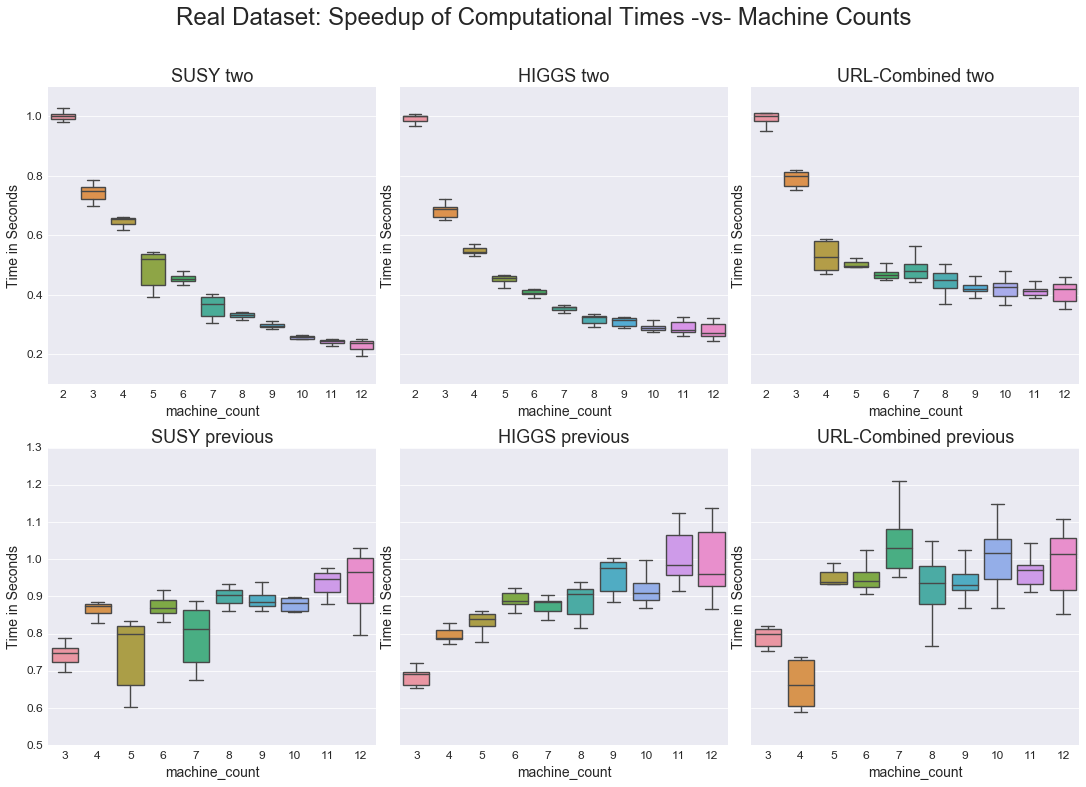

In [14]:
fig, axs = plt.subplots(2, num_datasets, figsize=(15,10), sharey='row')
table_df = pd.DataFrame(index=[i + 2 for i in range(total_machines - 1)], columns=dataset_names)
for dataset_index, dataset in enumerate(datasets):
    for exp_type_index, exp_type in enumerate(['two', 'previous']):
        df = pd.DataFrame(index=[i for i in range(trials*(total_machines - 1))], columns=['time', 'machine_count'])
        for machine_index, machine_count in enumerate(range(2, total_machines + 1)):
            if exp_type_index == 0:
                arr = []
                for k in range(trials):
                    arr.append(np.median(full_time_dict[dataset][2]['full'][k] - np.median(full_time_dict[dataset][2]['comm'])))
                median_for_2 = np.median(arr)
                arr = []
                for k in range(trials):
                    machine_time = full_time_dict[dataset][machine_count]['full'][k] - np.median(full_time_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [machine_time/median_for_2, machine_count]
                    arr.append(machine_time/median_for_2)
                table_df.loc[machine_count, dataset_names[dataset_index]] = np.median(arr)
            else:
                if machine_count == 2:
                    continue
                arr = []
                for k in range(trials):
                    arr.append(np.median(full_time_dict[dataset][machine_count - 1]['full'][k] - np.median(full_time_dict[dataset][machine_count - 1]['comm'])))
                median_for_prev = np.median(arr)
                for k in range(trials):
                    machine_time = full_time_dict[dataset][machine_count]['full'][k] - np.median(full_time_dict[dataset][machine_count]['comm'])
                    df.loc[trials*(machine_count - 2) + k] = [machine_time/median_for_prev, machine_count]
        ax = None
        if num_datasets == 1:
            ax = axs[exp_type_index]
        else:
            ax = axs[exp_type_index][dataset_index]
        sns.boxplot(list(df.time), groupby=df.machine_count, ax=ax, showfliers=False)
        set_fonts(ax, dataset_names[dataset_index] + ' ' + exp_type)
    fig.suptitle('Real Dataset: Speedup of Computational Times -vs- Machine Counts', fontsize=24, y=1.08)
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
table_df